In [2]:
# hack to import modules from outside this folder
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

import os

import tools
import effect
import player
import sound
from env import CrossAdaptiveEnv, DEFAULT_CONFIG

In [4]:
noise_path = "../input_audio/noise.wav"
amen_path = "../input_audio/amen.wav"
drums_path = "../input_audio/drums.wav"


In [5]:
def analyze_wav(wav_file):
    y, sr = librosa.load(wav_file, sr=44100)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    rms = librosa.feature.rms(y=y, frame_length=64)
    return [S, mfccs, rms]

## Resampling the RMS signal

919 7350


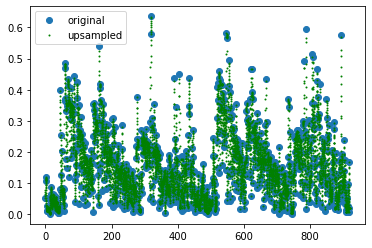

In [6]:
INPUT_FILE_PATH = drums_path
analysis = analyze_wav(drums_path)

_, _, rms = analysis
dur = tools.get_duration(INPUT_FILE_PATH)
n_k = int(dur * tools.k_per_sec()) # amount of k values we have to compute

x = np.linspace(0, rms.size, n_k)
xp = np.arange(rms.size)
yp = rms.flatten()
rms_interp = np.interp(x, xp, yp)
plt.plot(xp, yp, 'o', label="original")
plt.plot(x, rms_interp, 'go', linewidth=1, markersize=1, label="upsampled")
plt.legend()

print(rms.size, rms_interp.size)

## Applying the resample RMS as an audio effect 

In [26]:
fx = effect.Effect("freeverb")

config = DEFAULT_CONFIG
config["effect"] = fx
config["source"] = "amen.wav"
env = CrossAdaptiveEnv(config)

for rms_value in rms_interp:
    action = np.empty((len(fx.parameters),))
    action.fill(rms_value)
    state, reward, done, _ = env.step(action)
path = env.render()
tools.play_wav(path)